# LLC Frontogenesis Forcing Function

In [1]:
# imports
from importlib import reload

import os
import numpy as np

import pandas
import xarray
import h5py

from matplotlib import pyplot as plt
import seaborn as sns

from gsw import density

from ulmo import io as ulmo_io
from ulmo.plotting import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting
from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs

/home/xavier/Projects/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Main Table

In [2]:
tbl_file = 's3://llc/Tables/test_uniform_r0.5_test.feather'
llc_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://llc/Tables/test_uniform_r0.5_test.feather


In [3]:
llc_table['DT'] = llc_table.T90 - llc_table.T10

# Load up a field

In [4]:
high_DT = llc_table.DT > 4.
i4000 = np.argmin(np.abs(llc_table[high_DT].LL + 4000.))
cutout = llc_table[high_DT].iloc[i4000]
cutout

lat                                                         35.324909
lon                                                         -71.71875
row                                                              9856
col                                                             15629
datetime                                          2011-11-30 00:00:00
LLC_file            s3://llc/ThetaUVSalt/LLC4320_2011-11-30T00_00_...
pp_file                  s3://llc/PreProc/LLC_uniform_test_preproc.h5
pp_root                                                       llc_std
field_size                                                         64
mean_temperature                                            21.770691
Tmin                                                           16.167
Tmax                                                        25.351002
T90                                                         25.071001
T10                                                            16.607
pp_idx              

# Density

## Load dataset

In [5]:
local_file = os.path.join(os.getenv('LLC_DATA'), 
                          'ThetaUVSalt', os.path.basename(cutout.LLC_file))
ds = xarray.open_dataset(local_file)
ds

<xarray.Dataset>
Dimensions:  (i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_l: 1)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Dimensions without coordinates: k_l
Data variables:
    Theta    (j, i) float32 ...
    U        (j, i_g) float32 ...
    V        (j_g, i) float32 ...
    W        (k_l, j, i) float32 ...
    Salt     (j, i) float32 ...

In [6]:
salt = ds.Salt.values
np.median(salt[np.isfinite(salt)])

34.275

## Calculate 

In [7]:
global_rho = density.rho(salt, ds.Theta.values, np.zeros_like(salt))

## Show cutout

### SST

In [10]:
SST_cutout = ds.Theta[cutout.row:cutout.row+cutout.field_size, 
                cutout.col:cutout.col+cutout.field_size]

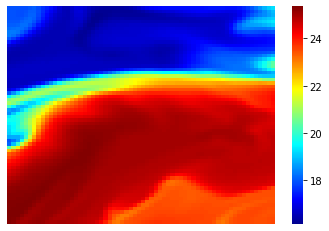

In [12]:
_ = plotting.show_image(SST_cutout)

### Salinity

In [18]:
salt_cutout = ds.Salt[cutout.row:cutout.row+cutout.field_size, 
                cutout.col:cutout.col+cutout.field_size]

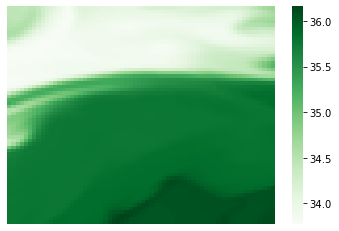

In [19]:
_ = plotting.show_image(salt_cutout, cm='Greens')

### Density

In [20]:
rho_cutout = global_rho[cutout.row:cutout.row+cutout.field_size, 
                cutout.col:cutout.col+cutout.field_size]

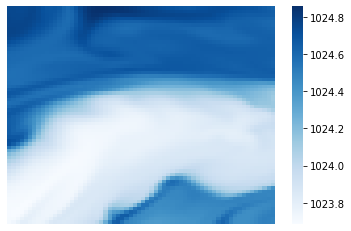

In [21]:
_ = plotting.show_image(rho_cutout, cm='Blues')

# Gradients on Density

In [42]:
ref_rho = 1.

## $\partial_x b$

In [43]:
dbdx = np.gradient(rho_cutout/ref_rho, axis=1)

## $\partial_y b$

In [44]:
dbdy = np.gradient(rho_cutout/ref_rho, axis=0)

# Current gradients

## Cutouts

In [45]:
U_cutout = ds.U[cutout.row:cutout.row+cutout.field_size, 
                cutout.col:cutout.col+cutout.field_size]
V_cutout = ds.V[cutout.row:cutout.row+cutout.field_size, 
                cutout.col:cutout.col+cutout.field_size]

## Gradients

In [46]:
dUdx = np.gradient(U_cutout, axis=1)
dVdx = np.gradient(V_cutout, axis=1)
#
dUdy = np.gradient(U_cutout, axis=0)
dVdy = np.gradient(V_cutout, axis=0)

# $F_s$: Frontogenesis forcing

## Calculate

In [47]:
F_S_x = -1 * (dUdx*dbdx + dVdx*dbdy) * dbdx 
F_S_y = -1 * (dUdy*dbdx + dVdy*dbdy) * dbdy 

In [48]:
F_S = F_S_x + F_S_y

## Show

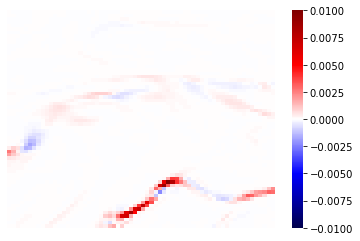

In [50]:
_ = plotting.show_image(F_S, cm='seismic', vmnx=(-0.01, 0.01))

----

# Simple test -- I hope

In [5]:
rho = density.rho(35., 20., 0.)
rho

1024.6396354289575